In [1]:
import warnings
warnings.filterwarnings('ignore')

Загружаем данные из подготовленного файла

In [ ]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files='готовые данные/bitumen_terminal_data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

Просматриваем правильно ли импортировалась таблица

In [3]:
dataset['train']['image_path']

['data/готовые данные/images/Елец_цвет.png',
 'data/готовые данные/images/Елец_чб.png',
 'data/готовые данные/images/Калининград_цвет.png',
 'data/готовые данные/images/Калининград_чб.png',
 'data/готовые данные/images/Кнайпеда_цвет.png',
 'data/готовые данные/images/Кнайпеда_чб.png',
 'data/готовые данные/images/Колпино_1_цвет.png',
 'data/готовые данные/images/Колпино_1_чб.png',
 'data/готовые данные/images/Колпино_2_цвет.png',
 'data/готовые данные/images/Колпино_2_чб.png',
 'data/готовые данные/images/Сальск_цвет.png',
 'data/готовые данные/images/Сальск_чб.png',
 'data/готовые данные/images/Талдом_цвет.png',
 'data/готовые данные/images/Талдом_чб.png',
 'data/готовые данные/images/Тюмень_цвет.png',
 'data/готовые данные/images/Тюмень_чб.png',
 'data/готовые данные/images/Яссы_цвет.png',
 'data/готовые данные/images/Яссы_чб.png']

Смотрим подгрузились ли изображения

In [4]:
for i in range(min(5, len(dataset["train"]))):  # Проверяем первые 5 строк
    print(dataset["train"][i]["image"])


None
None
None
None
None


Изображения не подгрузились, значит надо думать как их загрузить

-----

Выход нашли - с помощью ячейки image_path загружаем изображения и изменяем им тип на Image с помощью библиотеки datasets

c:\Users\nadyl\Desktop\kursovaya\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<class 'list'>


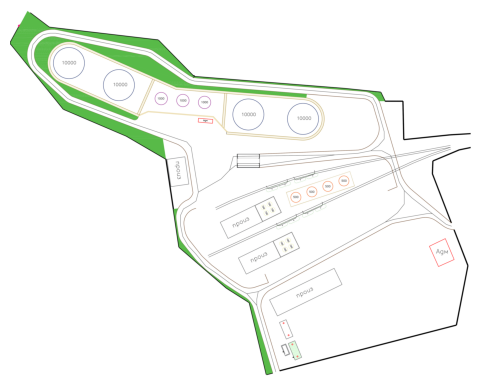

In [1]:
from datasets import load_dataset, Image
import os

# Загружаем CSV
dataset = load_dataset("csv", data_files="test_data.csv")['train']

# Проверяем, есть ли столбец "image" и удаляем его
if "image" in dataset.column_names:
    dataset = dataset.remove_columns(["image"])

# Функция для добавления изображений в датасет
def load_image(example):
    # print(example)
    if example.get("image_path"):  # Проверяем, что есть имя файла
        # print('Имя файла есть')
        image_path = os.path.join(example["image_path"])
        if os.path.exists(image_path):  # Проверяем, что файл существует
            # print('Файл существует')
            return {"image": image_path}
    return {"image": None}  # Если пути нет, ставим None

# Применяем функцию к dataset
dataset = dataset.map(load_image, batched=False)
# print(dataset[:5], 'датасет после map')
# print(dataset['image'])

# Удаляем строки с отсутствующими изображениями (по желанию)
dataset = dataset.filter(lambda x: x["image"] is not None)
# print(dataset, ' датасет после filter')

# Преобразуем столбец в формат Image
dataset = dataset.cast_column("image", Image())
print(type(dataset['image']))

# Проверяем одно изображение
import matplotlib.pyplot as plt

example = dataset[0]["image"]
plt.imshow(example)
plt.axis("off")
plt.show()

У нас получилось загрузить изображение!

Просматриваем сразу несколько изображений во избежании ошибок

C:\Users\nadyl\AppData\Local\Temp\ipykernel_9568\3278871621.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


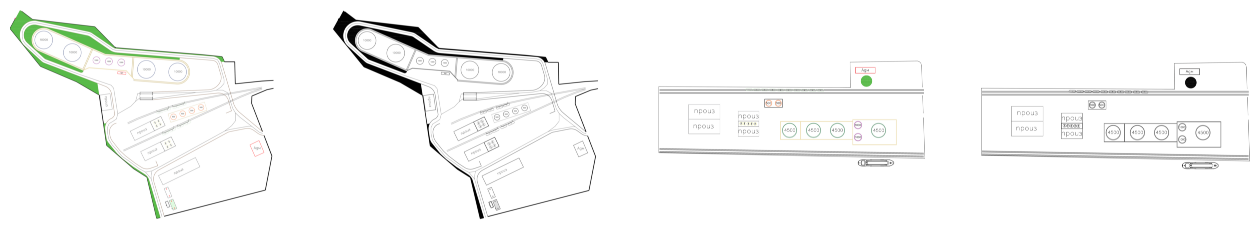

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

Создаём конфигурацию обработки изображений при загрузке в модель (Размеры)

In [3]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.8], [0.2]),
    ]
)

Используя ранее сделанную конфигурацию изменяем все изображения

In [4]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

Смотрим изображения после преобработки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5..1.0].
C:\Users\nadyl\AppData\Local\Temp\ipykernel_9568\948138263.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


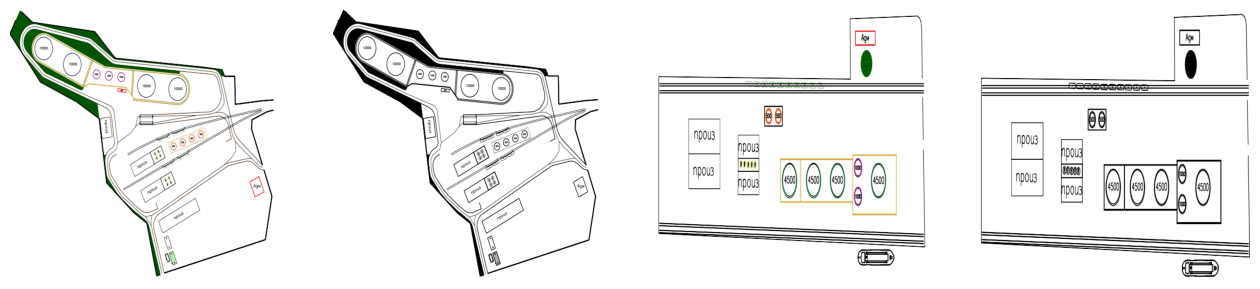

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

## Создание самой модели

In [6]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

Создаём конфигурацию для модели UNet2Model

In [ ]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=512,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=3,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

In [8]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 512, 512])


In [9]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 512, 512])


## Добавление шума

In [10]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1)

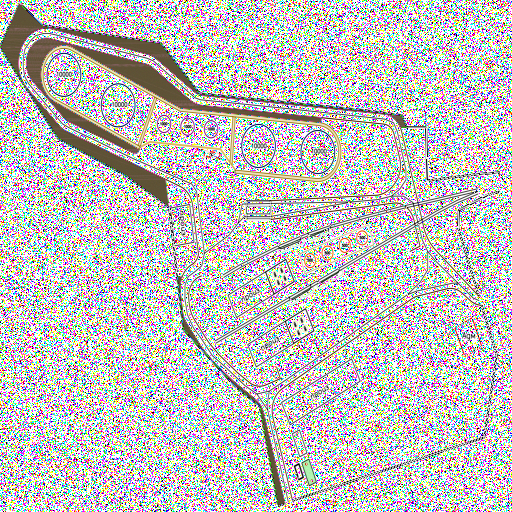

In [11]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([0])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [12]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.0710, grad_fn=<MseLossBackward0>)


## Параметры для обучения

In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [27]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=(len(train_dataloader) * 10),
)

In [ ]:
from diffusers import DDPMPipeline

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = 2, 
        generator=torch.manual_seed(0),
        num_inference_steps=1,
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join('test', "samples") 
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

## Обучение с шумом

In [ ]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, whoami

from tqdm.auto import tqdm
import os

import os
os.environ ['CUDA_LAUNCH_BLOCKING'] ='1'
def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision='fp16',
        gradient_accumulation_steps=1, 
        log_with="tensorboard",
        project_dir=os.path.join('test', "logs")
    )
    if accelerator.is_main_process:
        if 'test' != None:
            os.makedirs('test', exist_ok=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(10):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % 2 == 0 or epoch == 10 - 1:
                evaluate(epoch, pipeline)

            if (epoch + 1) % 5 == 0 or epoch == 10 - 1:
                pipeline.save_pretrained('models') 

In [35]:
# from accelerate import notebook_launcher
# args = (model, optimizer, train_dataloader, lr_scheduler)

# notebook_launcher(train_loop, args, num_processes=1)

## Обучение без шума

In [ ]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, whoami

from tqdm.auto import tqdm
import os

import os
os.environ ['CUDA_LAUNCH_BLOCKING'] ='1'
def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(model, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision='fp16',
        gradient_accumulation_steps=1, 
        log_with="tensorboard",
        project_dir=os.path.join('test', "logs")
    )
    if accelerator.is_main_process:
        if 'test' != None:
            os.makedirs('test', exist_ok=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(10):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            
            with accelerator.accumulate(model):
                # Передаём фиксированный timestep, так как он обязателен для модели
                timesteps = torch.tensor(0, device=clean_images.device).long()
                
                # Предсказание модели на чистых изображениях
                output = model(clean_images, timesteps, return_dict=False)[0]
                
                # Определите функцию потерь, соответствующую вашей задаче
                loss = F.mse_loss(output, clean_images)  # Например, MSE между предсказанием и входом
                
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % 2 == 0 or epoch == 10 - 1:
                evaluate(epoch, pipeline)

            if (epoch + 1) % 5 == 0 or epoch == 10 - 1:
                pipeline.save_pretrained('models') 

In [37]:
from accelerate import notebook_launcher
args = (model, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


Epoch 0: 100%|██████████| 18/18 [04:42<00:00, 15.61s/it, loss=0.0284, lr=1.06e-5, step=17]

Epoch 0: 100%|██████████| 18/18 [04:42<00:00, 15.69s/it, loss=0.0284, lr=1.06e-5, step=17]










































































Epoch 2: 100%|██████████| 18/18 [04:48<00:00, 15.86s/it, loss=0.0114, lr=1.78e-5, step=53]

Epoch 2: 100%|██████████| 18/18 [04:48<00:00, 16.05s/it, loss=0.0114, lr=1.78e-5, step=53]










































































Epoch 4: 100%|██████████| 18/18 [04:51<00:00, 15.92s/it, loss=0.00804, lr=2.5e-5, step=89] 

Epoch 4: 100%|██████████| 18/18 [04:52<00:00, 16.23s/it, loss=0.00804, lr=2.5e-5, step=89]










































































Epoch 6: 100%|██████████| 18/18 [04:41<00:00, 15.47s/it, loss=0.00533, lr=3.22e-5, step=125]

Epoch 6: 100%|██████████| 18/18 [04:41<00:00, 15.65s/it, loss=0.00533, lr=3.22e-5, step=125]









































